# GPT-4o Response Analysis - Image Experiment

Investigating GPT-4o and GPT-4o-mini error patterns in the image-based experiment.

In [1]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt

# Load and parse data
df = pd.read_csv('model_responses_image.csv')

def extract_percentages(result_str):
    try:
        match = re.search(r'<answer>\s*(\{.*?\})\s*</answer>', result_str, re.DOTALL)
        if match:
            return json.loads(match.group(1))
    except:
        pass
    return None

df['percentages'] = df['result'].apply(extract_percentages)
df['blue_pct'] = df['percentages'].apply(lambda x: x.get('blue', np.nan) if x else np.nan)
df['purple_pct'] = df['percentages'].apply(lambda x: x.get('purple', np.nan) if x else np.nan)
df['red_pct'] = df['percentages'].apply(lambda x: x.get('red', np.nan) if x else np.nan)
df['green_pct'] = df['percentages'].apply(lambda x: x.get('green', np.nan) if x else np.nan)

# Apply color mapping for image experiment set 2: ('green', 'red', 'blue', 'purple')
# This is DIFFERENT from main experiment set 2: ('green', 'red', 'purple', 'blue')
color_set_2 = "('green', 'red', 'blue', 'purple')"
mask_set2 = df['colors'] == color_set_2

df['blue_mapped'] = df['blue_pct'].copy()
df['purple_mapped'] = df['purple_pct'].copy()
df['red_mapped'] = df['red_pct'].copy()
df['green_mapped'] = df['green_pct'].copy()

# For image experiment: ('green', 'red', 'blue', 'purple')
# green is in blue's position -> green becomes blue
# red is in purple's position -> red becomes purple
# blue is in red's position -> blue becomes red
# purple is in green's position -> purple becomes green
df.loc[mask_set2, 'blue_mapped'] = df.loc[mask_set2, 'green_pct']
df.loc[mask_set2, 'purple_mapped'] = df.loc[mask_set2, 'red_pct']
df.loc[mask_set2, 'red_mapped'] = df.loc[mask_set2, 'blue_pct']
df.loc[mask_set2, 'green_mapped'] = df.loc[mask_set2, 'purple_pct']

print('Data loaded successfully')
print(f'Total rows: {len(df)}')
print(f'Color sets: {df["colors"].unique()}')

Data loaded successfully
Total rows: 450
Color sets: ["('blue', 'purple', 'red', 'green')" "('green', 'red', 'blue', 'purple')"]


## 1. Distribution of Blue Container Responses by Model

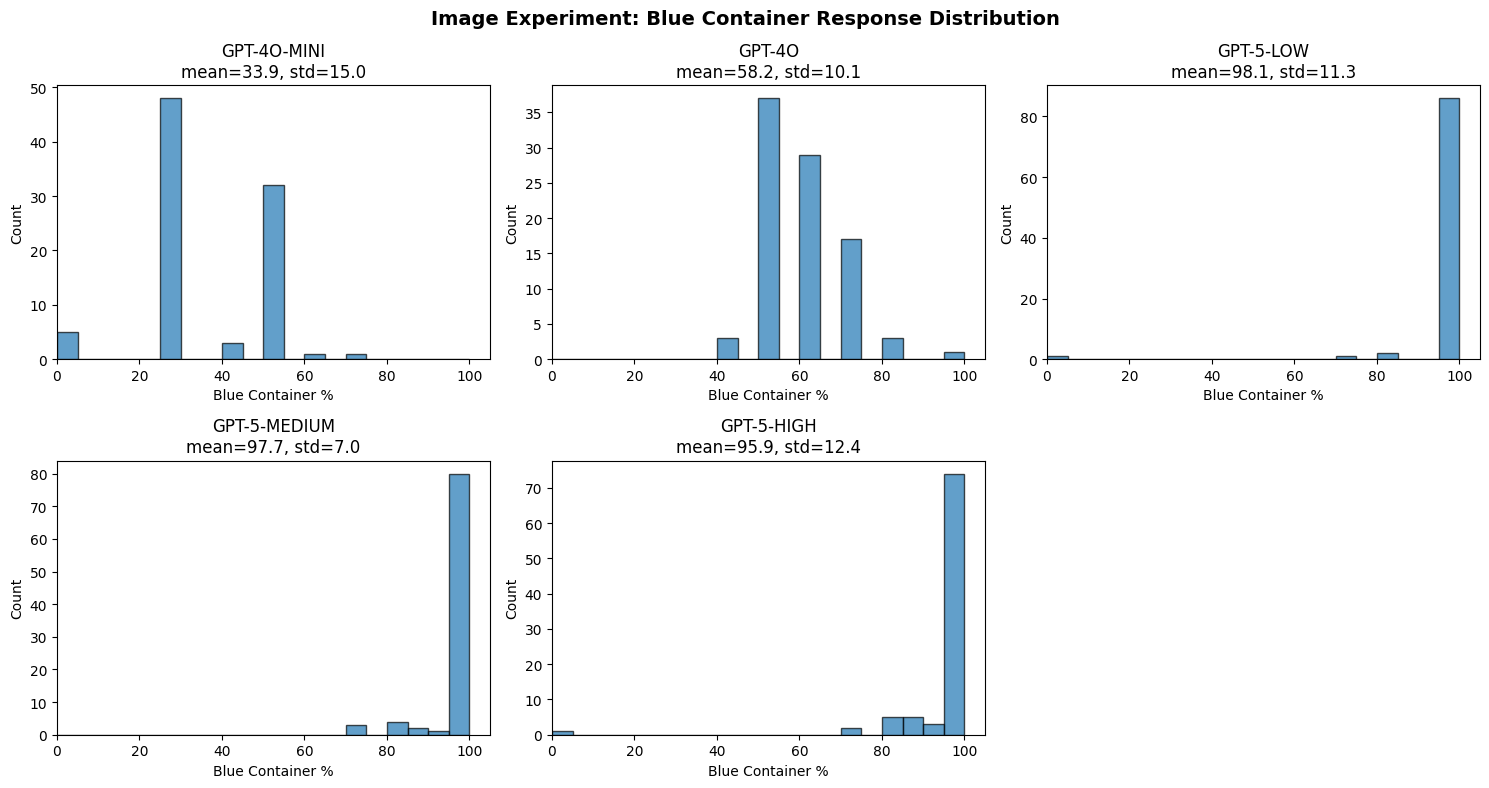

In [2]:
# Compare distributions across models
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
models = ['gpt-4o-mini', 'gpt-4o', 'gpt-5-low', 'gpt-5-medium', 'gpt-5-high']

for idx, model in enumerate(models):
    ax = axes[idx // 3, idx % 3]
    model_data = df[df['model'] == model]['blue_mapped'].dropna()
    ax.hist(model_data, bins=20, range=(0, 100), edgecolor='black', alpha=0.7)
    ax.set_title(f'{model.upper()}\nmean={model_data.mean():.1f}, std={model_data.std():.1f}')
    ax.set_xlabel('Blue Container %')
    ax.set_ylabel('Count')
    ax.set_xlim(0, 105)

axes[1, 2].axis('off')
plt.suptitle('Image Experiment: Blue Container Response Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('gpt4o_image_analysis_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. GPT-4o Response Patterns by Condition

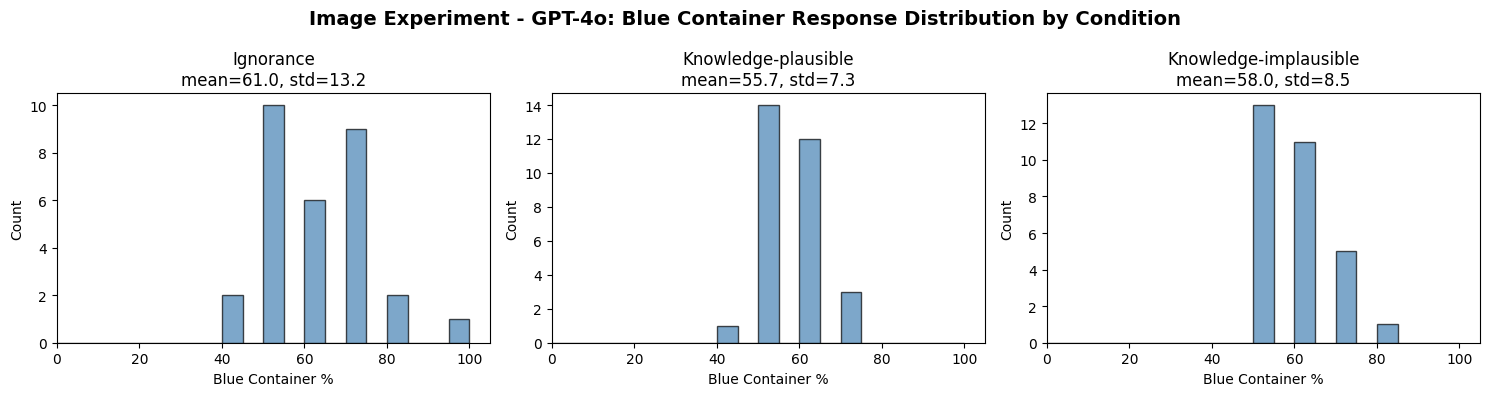

In [3]:
# GPT-4o distribution by condition
gpt4o = df[df['model'] == 'gpt-4o']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
conditions = ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']

for idx, cond in enumerate(conditions):
    ax = axes[idx]
    cond_data = gpt4o[gpt4o['condition'] == cond]['blue_mapped'].dropna()
    ax.hist(cond_data, bins=20, range=(0, 100), edgecolor='black', alpha=0.7, color='steelblue')
    ax.set_title(f'{cond}\nmean={cond_data.mean():.1f}, std={cond_data.std():.1f}')
    ax.set_xlabel('Blue Container %')
    ax.set_ylabel('Count')
    ax.set_xlim(0, 105)

plt.suptitle('Image Experiment - GPT-4o: Blue Container Response Distribution by Condition', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('gpt4o_image_analysis_by_condition.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Categorize GPT-4o and GPT-4o-mini Response Types

In [4]:
# Categorize response types
def categorize_response(blue_pct):
    if pd.isna(blue_pct):
        return 'Invalid'
    elif blue_pct >= 95:
        return 'Correct (100%)'
    elif 20 <= blue_pct <= 30:
        return 'Uniform (25%)'
    elif blue_pct <= 5:
        return 'Wrong (0%)'
    else:
        return 'Other'

gpt4o = df[df['model'] == 'gpt-4o'].copy()
gpt4o['response_type'] = gpt4o['blue_mapped'].apply(categorize_response)

gpt4o_mini = df[df['model'] == 'gpt-4o-mini'].copy()
gpt4o_mini['response_type'] = gpt4o_mini['blue_mapped'].apply(categorize_response)

# Count by condition for GPT-4o
response_counts_4o = gpt4o.groupby(['condition', 'response_type']).size().unstack(fill_value=0)
print('GPT-4o Response Type Counts by Condition:')
print('='*60)
display(response_counts_4o)

response_pct_4o = response_counts_4o.div(response_counts_4o.sum(axis=1), axis=0) * 100
print('\nGPT-4o Response Type Percentages by Condition:')
print('='*60)
display(response_pct_4o.round(1))

# Count by condition for GPT-4o-mini
response_counts_mini = gpt4o_mini.groupby(['condition', 'response_type']).size().unstack(fill_value=0)
print('\n\nGPT-4o-mini Response Type Counts by Condition:')
print('='*60)
display(response_counts_mini)

response_pct_mini = response_counts_mini.div(response_counts_mini.sum(axis=1), axis=0) * 100
print('\nGPT-4o-mini Response Type Percentages by Condition:')
print('='*60)
display(response_pct_mini.round(1))

GPT-4o Response Type Counts by Condition:


response_type,Correct (100%),Other
condition,,
Ignorance,1,29
Knowledge-implausible,0,30
Knowledge-plausible,0,30



GPT-4o Response Type Percentages by Condition:


response_type,Correct (100%),Other
condition,,
Ignorance,3.3,96.7
Knowledge-implausible,0.0,100.0
Knowledge-plausible,0.0,100.0




GPT-4o-mini Response Type Counts by Condition:


response_type,Other,Uniform (25%),Wrong (0%)
condition,,,
Ignorance,14,16,0
Knowledge-implausible,13,16,1
Knowledge-plausible,10,16,4



GPT-4o-mini Response Type Percentages by Condition:


response_type,Other,Uniform (25%),Wrong (0%)
condition,,,
Ignorance,46.7,53.3,0.0
Knowledge-implausible,43.3,53.3,3.3
Knowledge-plausible,33.3,53.3,13.3


In [5]:
# Breakdown by Color Mapping
print("GPT-4o Response Types by Color Set")
print("="*70)

gpt4o['color_set'] = gpt4o['colors'].apply(lambda x: 'Set 1 (blue first)' if 'blue' in x[:20] else 'Set 2 (green first)')

# Count by color set and response type
color_breakdown = gpt4o.groupby(['color_set', 'response_type']).size().unstack(fill_value=0)
print("\nCounts:")
display(color_breakdown)

# Percentage
color_pct = color_breakdown.div(color_breakdown.sum(axis=1), axis=0) * 100
print("\nPercentages:")
display(color_pct.round(1))

# Also show by condition within each color set
print("\n" + "="*70)
print("Breakdown by Color Set AND Condition:")
print("="*70)
for color_set in ['Set 1 (blue first)', 'Set 2 (green first)']:
    print(f"\n--- {color_set} ---")
    subset = gpt4o[gpt4o['color_set'] == color_set]
    breakdown = subset.groupby(['condition', 'response_type']).size().unstack(fill_value=0)
    display(breakdown)

GPT-4o Response Types by Color Set

Counts:


response_type,Correct (100%),Other
color_set,,
Set 1 (blue first),0,45
Set 2 (green first),1,44



Percentages:


response_type,Correct (100%),Other
color_set,,
Set 1 (blue first),0.0,100.0
Set 2 (green first),2.2,97.8



Breakdown by Color Set AND Condition:

--- Set 1 (blue first) ---


response_type,Other
condition,
Ignorance,15
Knowledge-implausible,15
Knowledge-plausible,15



--- Set 2 (green first) ---


response_type,Correct (100%),Other
condition,,
Ignorance,1,14
Knowledge-implausible,0,15
Knowledge-plausible,0,15


In [6]:
# Detailed breakdown of actual percentage values by condition for GPT-4o and GPT-4o-mini
print("="*100)
print("DETAILED PERCENTAGE BREAKDOWN BY CONDITION")
print("="*100)

for model_name, model_data in [('GPT-4o', gpt4o), ('GPT-4o-mini', gpt4o_mini)]:
    print(f"\n{'#'*100}")
    print(f"# {model_name.upper()}")
    print(f"{'#'*100}")
    
    for condition in ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']:
        cond_data = model_data[model_data['condition'] == condition]
        
        print(f"\n--- {condition} (n={len(cond_data)}) ---")
        print(f"\nBlue (mapped) statistics:")
        print(f"  Mean: {cond_data['blue_mapped'].mean():.1f}%")
        print(f"  Std:  {cond_data['blue_mapped'].std():.1f}%")
        print(f"  Min:  {cond_data['blue_mapped'].min():.1f}%")
        print(f"  Max:  {cond_data['blue_mapped'].max():.1f}%")
        
        print(f"\nBlue percentage value counts:")
        value_counts = cond_data['blue_mapped'].value_counts().sort_index()
        for val, count in value_counts.items():
            pct = count / len(cond_data) * 100
            print(f"  {val:5.1f}%: {count:2} cases ({pct:5.1f}%)")
        
        print(f"\nAll container means (mapped):")
        print(f"  Blue:   {cond_data['blue_mapped'].mean():.1f}%")
        print(f"  Purple: {cond_data['purple_mapped'].mean():.1f}%")
        print(f"  Red:    {cond_data['red_mapped'].mean():.1f}%")
        print(f"  Green:  {cond_data['green_mapped'].mean():.1f}%")

DETAILED PERCENTAGE BREAKDOWN BY CONDITION

####################################################################################################
# GPT-4O
####################################################################################################

--- Ignorance (n=30) ---

Blue (mapped) statistics:
  Mean: 61.0%
  Std:  13.2%
  Min:  40.0%
  Max:  100.0%

Blue percentage value counts:
   40.0%:  2 cases (  6.7%)
   50.0%: 10 cases ( 33.3%)
   60.0%:  6 cases ( 20.0%)
   70.0%:  9 cases ( 30.0%)
   80.0%:  2 cases (  6.7%)
  100.0%:  1 cases (  3.3%)

All container means (mapped):
  Blue:   61.0%
  Purple: 12.4%
  Red:    13.9%
  Green:  12.6%

--- Knowledge-plausible (n=30) ---

Blue (mapped) statistics:
  Mean: 55.7%
  Std:  7.3%
  Min:  40.0%
  Max:  70.0%

Blue percentage value counts:
   40.0%:  1 cases (  3.3%)
   50.0%: 14 cases ( 46.7%)
   60.0%: 12 cases ( 40.0%)
   70.0%:  3 cases ( 10.0%)

All container means (mapped):
  Blue:   55.7%
  Purple: 7.0%
  Red:    26.7%
  

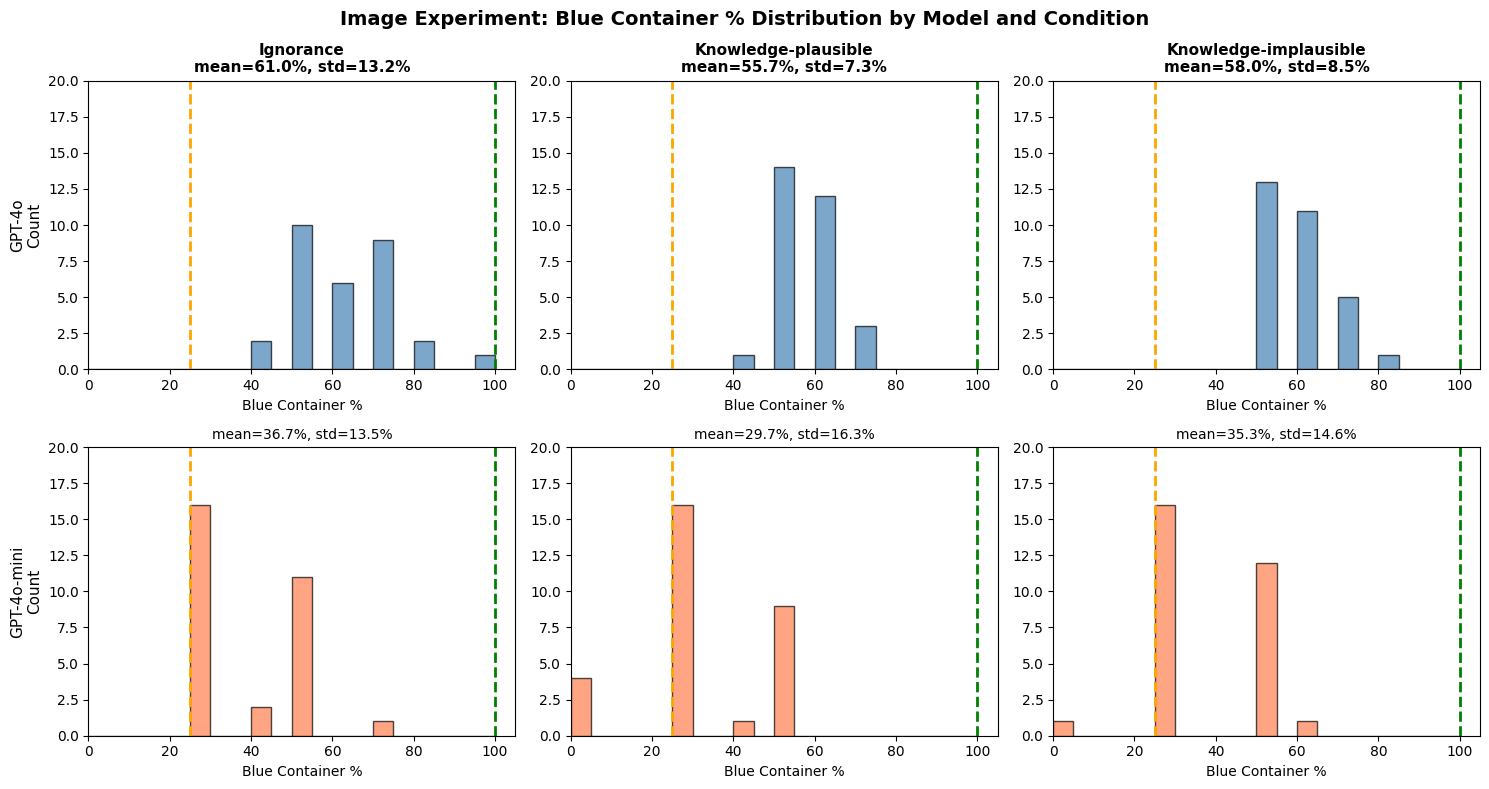


Note: Green dashed line = Correct answer (100%), Orange dashed line = Uniform (25%)


In [7]:
# Visual comparison: Distribution of blue percentages by condition for both models
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
conditions = ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']

for col, condition in enumerate(conditions):
    for row, (model_name, model_data) in enumerate([('GPT-4o', gpt4o), ('GPT-4o-mini', gpt4o_mini)]):
        ax = axes[row, col]
        cond_data = model_data[model_data['condition'] == condition]['blue_mapped'].dropna()
        
        ax.hist(cond_data, bins=20, range=(0, 100), edgecolor='black', alpha=0.7, 
                color='steelblue' if row == 0 else 'coral')
        ax.axvline(x=100, color='green', linestyle='--', linewidth=2, label='Correct (100%)')
        ax.axvline(x=25, color='orange', linestyle='--', linewidth=2, label='Uniform (25%)')
        
        ax.set_xlabel('Blue Container %')
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 20)
        
        mean_val = cond_data.mean()
        std_val = cond_data.std()
        
        if row == 0:
            ax.set_title(f'{condition}\nmean={mean_val:.1f}%, std={std_val:.1f}%', fontsize=11, fontweight='bold')
        else:
            ax.set_title(f'mean={mean_val:.1f}%, std={std_val:.1f}%', fontsize=10)
        
        if col == 0:
            ax.set_ylabel(f'{model_name}\nCount', fontsize=11)

plt.suptitle('Image Experiment: Blue Container % Distribution by Model and Condition', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('gpt4o_image_analysis_distribution_by_condition.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nNote: Green dashed line = Correct answer (100%), Orange dashed line = Uniform (25%)")

## 4. Detailed Case Analysis

In [8]:
# Show ALL Wrong (0%) cases for GPT-4o, grouped by condition
print("="*100)
print("ALL GPT-4o Cases with 0% Blue (Wrong Responses) - Grouped by Condition")
print("="*100)

wrong_cases = gpt4o[gpt4o['response_type'] == 'Wrong (0%)'].copy()
print(f"\nTotal: {len(wrong_cases)} cases\n")

for condition in ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']:
    cond_cases = wrong_cases[wrong_cases['condition'] == condition]
    print(f"\n{'#'*100}")
    print(f"# {condition.upper()} ({len(cond_cases)} cases)")
    print(f"{'#'*100}")
    
    for idx, (_, row) in enumerate(cond_cases.iterrows(), 1):
        print(f"\n{'='*100}")
        print(f"CASE {idx}/{len(cond_cases)} - {condition}")
        print(f"{'='*100}")
        print(f"Names: {row['names']}")
        print(f"Colors: {row['colors']}")
        print(f"Trial: {row['trial']}")
        print(f"\nRaw percentages: blue={row['blue_pct']}, purple={row['purple_pct']}, red={row['red_pct']}, green={row['green_pct']}")
        print(f"Mapped percentages: blue={row['blue_mapped']}, purple={row['purple_mapped']}, red={row['red_mapped']}, green={row['green_mapped']}")
        print(f"\n--- FULL RESPONSE ---")
        print(row['result'])

ALL GPT-4o Cases with 0% Blue (Wrong Responses) - Grouped by Condition

Total: 0 cases


####################################################################################################
# IGNORANCE (0 cases)
####################################################################################################

####################################################################################################
# KNOWLEDGE-PLAUSIBLE (0 cases)
####################################################################################################

####################################################################################################
# KNOWLEDGE-IMPLAUSIBLE (0 cases)
####################################################################################################


In [9]:
# Show ALL Uniform (25%) cases for GPT-4o, grouped by condition
print("="*100)
print("ALL GPT-4o Cases with ~25% Each (Uniform Responses) - Grouped by Condition")
print("="*100)

uniform_cases = gpt4o[gpt4o['response_type'] == 'Uniform (25%)'].copy()
print(f"\nTotal: {len(uniform_cases)} cases\n")

for condition in ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']:
    cond_cases = uniform_cases[uniform_cases['condition'] == condition]
    print(f"\n{'#'*100}")
    print(f"# {condition.upper()} ({len(cond_cases)} cases)")
    print(f"{'#'*100}")
    
    for idx, (_, row) in enumerate(cond_cases.iterrows(), 1):
        print(f"\n{'='*100}")
        print(f"CASE {idx}/{len(cond_cases)} - {condition}")
        print(f"{'='*100}")
        print(f"Names: {row['names']}")
        print(f"Colors: {row['colors']}")
        print(f"Trial: {row['trial']}")
        print(f"\nRaw percentages: blue={row['blue_pct']}, purple={row['purple_pct']}, red={row['red_pct']}, green={row['green_pct']}")
        print(f"Mapped percentages: blue={row['blue_mapped']}, purple={row['purple_mapped']}, red={row['red_mapped']}, green={row['green_mapped']}")
        print(f"\n--- FULL RESPONSE ---")
        print(row['result'])

ALL GPT-4o Cases with ~25% Each (Uniform Responses) - Grouped by Condition

Total: 0 cases


####################################################################################################
# IGNORANCE (0 cases)
####################################################################################################

####################################################################################################
# KNOWLEDGE-PLAUSIBLE (0 cases)
####################################################################################################

####################################################################################################
# KNOWLEDGE-IMPLAUSIBLE (0 cases)
####################################################################################################


In [10]:
# Show SAMPLE of Other cases for GPT-4o (since responses are just JSON with no explanations)
print("="*100)
print("SAMPLE GPT-4o 'Other' Cases - By Condition (3 per condition)")
print("="*100)
print("\nNote: GPT-4o image responses contain only JSON answers with no explanations.")

other_cases = gpt4o[gpt4o['response_type'] == 'Other']

for condition in ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']:
    cond_cases = other_cases[other_cases['condition'] == condition]
    print(f"\n{'#'*80}")
    print(f"# {condition.upper()} ({len(cond_cases)} total cases - showing 3)")
    print(f"{'#'*80}")
    
    for idx, (_, row) in enumerate(cond_cases.head(3).iterrows(), 1):
        print(f"\nCase {idx}: Trial {row['trial']}, Colors: {row['colors']}")
        print(f"  Mapped: blue={row['blue_mapped']:.0f}%, purple={row['purple_mapped']:.0f}%, red={row['red_mapped']:.0f}%, green={row['green_mapped']:.0f}%")

SAMPLE GPT-4o 'Other' Cases - By Condition (3 per condition)

Note: GPT-4o image responses contain only JSON answers with no explanations.

################################################################################
# IGNORANCE (29 total cases - showing 3)
################################################################################

Case 1: Trial 0, Colors: ('blue', 'purple', 'red', 'green')
  Mapped: blue=70%, purple=10%, red=10%, green=10%

Case 2: Trial 1, Colors: ('blue', 'purple', 'red', 'green')
  Mapped: blue=50%, purple=20%, red=15%, green=15%

Case 3: Trial 2, Colors: ('blue', 'purple', 'red', 'green')
  Mapped: blue=50%, purple=20%, red=20%, green=10%

################################################################################
# KNOWLEDGE-PLAUSIBLE (30 total cases - showing 3)
################################################################################

Case 1: Trial 0, Colors: ('blue', 'purple', 'red', 'green')
  Mapped: blue=60%, purple=10%, red=20%, green

## 5. GPT-4o vs GPT-4o-mini Comparison by Condition

GPT-4o vs GPT-4o-mini: Response Types by Condition

GPT-4o Response Type Summary:
response_type
Other             89
Correct (100%)     1
Name: count, dtype: int64

GPT-4o-mini Response Type Summary:
response_type
Uniform (25%)    48
Other            37
Wrong (0%)        5
Name: count, dtype: int64

Detailed Breakdown by Condition

################################################################################
# IGNORANCE
################################################################################

--- GPT-4o (n=30) ---
  Correct (100%)      :   1 (  3.3%)
  Uniform (25%)       :   0 (  0.0%)
  Wrong (0%)          :   0 (  0.0%)
  Other               :  29 ( 96.7%)
  Invalid             :   0 (  0.0%)

--- GPT-4o-mini (n=30) ---
  Correct (100%)      :   0 (  0.0%)
  Uniform (25%)       :  16 ( 53.3%)
  Wrong (0%)          :   0 (  0.0%)
  Other               :  14 ( 46.7%)
  Invalid             :   0 (  0.0%)

######################################################################

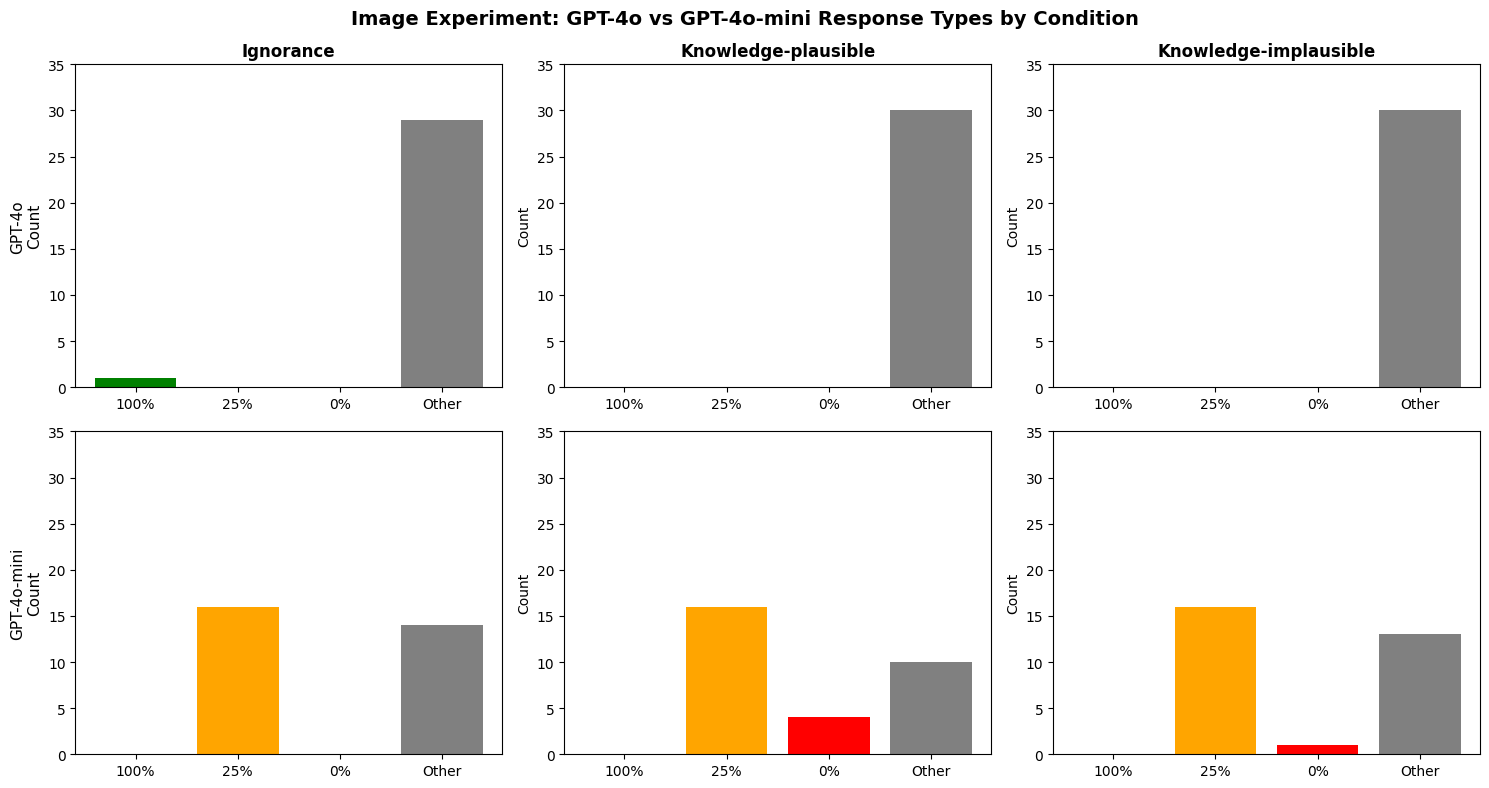

In [11]:
# Compare GPT-4o and GPT-4o-mini by condition
print("="*100)
print("GPT-4o vs GPT-4o-mini: Response Types by Condition")
print("="*100)

# Summary counts
print("\nGPT-4o Response Type Summary:")
print(gpt4o['response_type'].value_counts())
print("\nGPT-4o-mini Response Type Summary:")
print(gpt4o_mini['response_type'].value_counts())

# Breakdown by condition for both models
print("\n" + "="*100)
print("Detailed Breakdown by Condition")
print("="*100)

for condition in ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']:
    print(f"\n{'#'*80}")
    print(f"# {condition.upper()}")
    print(f"{'#'*80}")
    
    for model_name, model_data in [('GPT-4o', gpt4o), ('GPT-4o-mini', gpt4o_mini)]:
        cond_data = model_data[model_data['condition'] == condition]
        counts = cond_data['response_type'].value_counts()
        total = len(cond_data)
        
        print(f"\n--- {model_name} (n={total}) ---")
        for resp_type in ['Correct (100%)', 'Uniform (25%)', 'Wrong (0%)', 'Other', 'Invalid']:
            count = counts.get(resp_type, 0)
            pct = (count / total * 100) if total > 0 else 0
            print(f"  {resp_type:20}: {count:3} ({pct:5.1f}%)")

# Visual comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
conditions = ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']
response_types = ['Correct (100%)', 'Uniform (25%)', 'Wrong (0%)', 'Other']
colors = ['green', 'orange', 'red', 'gray']

for col, condition in enumerate(conditions):
    for row, (model_name, model_data) in enumerate([('GPT-4o', gpt4o), ('GPT-4o-mini', gpt4o_mini)]):
        ax = axes[row, col]
        cond_data = model_data[model_data['condition'] == condition]
        counts = [cond_data[cond_data['response_type'] == rt].shape[0] for rt in response_types]
        
        ax.bar(range(len(response_types)), counts, color=colors)
        ax.set_xticks(range(len(response_types)))
        ax.set_xticklabels(['100%', '25%', '0%', 'Other'], rotation=0)
        ax.set_ylabel('Count')
        ax.set_ylim(0, 35)
        
        if row == 0:
            ax.set_title(f'{condition}', fontsize=12, fontweight='bold')
        if col == 0:
            ax.set_ylabel(f'{model_name}\nCount', fontsize=11)

plt.suptitle('Image Experiment: GPT-4o vs GPT-4o-mini Response Types by Condition', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('gpt4o_image_analysis_response_types.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Show ALL GPT-4o-mini Wrong (0%) cases with FULL responses
print("="*100)
print("ALL GPT-4o-mini Wrong (0%) Cases - FULL RESPONSES - Grouped by Condition")
print("="*100)

gpt4o_mini_wrong = gpt4o_mini[gpt4o_mini['response_type'] == 'Wrong (0%)'].copy()
print(f"\nTotal: {len(gpt4o_mini_wrong)} cases\n")

for condition in ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']:
    cond_cases = gpt4o_mini_wrong[gpt4o_mini_wrong['condition'] == condition]
    print(f"\n{'#'*100}")
    print(f"# {condition.upper()} ({len(cond_cases)} cases)")
    print(f"{'#'*100}")

    for idx, (_, row) in enumerate(cond_cases.iterrows(), 1):
        print(f"\n{'='*100}")
        print(f"CASE {idx}/{len(cond_cases)}")
        print(f"{'='*100}")
        print(f"Colors: {row['colors']}")
        print(f"Trial: {row['trial']}")
        print(f"Mapped: blue={row['blue_mapped']}, purple={row['purple_mapped']}, red={row['red_mapped']}, green={row['green_mapped']}")
        print(f"\n--- FULL RESPONSE ---")
        print(row['result'])

ALL GPT-4o-mini Wrong (0%) Cases - FULL RESPONSES - Grouped by Condition

Total: 5 cases


####################################################################################################
# IGNORANCE (0 cases)
####################################################################################################

####################################################################################################
# KNOWLEDGE-PLAUSIBLE (4 cases)
####################################################################################################

CASE 1/4
Colors: ('green', 'red', 'blue', 'purple')
Trial: 2
Mapped: blue=0.0, purple=25.0, red=75.0, green=0.0

--- FULL RESPONSE ---
<answer>
{
    "green": 0,
    "red": 25,
    "blue": 75,
    "purple": 0
}
</answer>

CASE 2/4
Colors: ('green', 'red', 'blue', 'purple')
Trial: 3
Mapped: blue=0.0, purple=25.0, red=75.0, green=0.0

--- FULL RESPONSE ---
<answer>
{
    "green": 0,
    "red": 25,
    "blue": 75,
    "purple": 0
}
</answer>

CASE 

In [13]:
# Show sample GPT-4o-mini Uniform (25%) and Other cases with FULL responses
print("="*100)
print("SAMPLE GPT-4o-mini Uniform (25%) and Other Cases - FULL RESPONSES")
print("="*100)

for response_type in ['Uniform (25%)', 'Other']:
    type_cases = gpt4o_mini[gpt4o_mini['response_type'] == response_type]
    print(f"\n{'#'*100}")
    print(f"# {response_type.upper()} ({len(type_cases)} total cases)")
    print(f"{'#'*100}")
    
    for condition in ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']:
        cond_cases = type_cases[type_cases['condition'] == condition]
        print(f"\n--- {condition} ({len(cond_cases)} cases) - Showing first 3 ---")
        
        for idx, (_, row) in enumerate(cond_cases.head(3).iterrows(), 1):
            print(f"\n{'='*80}")
            print(f"CASE {idx}")
            print(f"{'='*80}")
            print(f"Colors: {row['colors']}")
            print(f"Trial: {row['trial']}")
            print(f"Mapped: blue={row['blue_mapped']}, purple={row['purple_mapped']}, red={row['red_mapped']}, green={row['green_mapped']}")
            print(f"\n--- FULL RESPONSE ---")
            print(row['result'])

SAMPLE GPT-4o-mini Uniform (25%) and Other Cases - FULL RESPONSES

####################################################################################################
# UNIFORM (25%) (48 total cases)
####################################################################################################

--- Ignorance (16 cases) - Showing first 3 ---

CASE 1
Colors: ('blue', 'purple', 'red', 'green')
Trial: 0
Mapped: blue=25.0, purple=25.0, red=25.0, green=25.0

--- FULL RESPONSE ---
<answer>
{
    "blue": 25,
    "purple": 25,
    "red": 25,
    "green": 25
}
</answer>

CASE 2
Colors: ('blue', 'purple', 'red', 'green')
Trial: 2
Mapped: blue=25.0, purple=25.0, red=25.0, green=25.0

--- FULL RESPONSE ---
<answer>
{
    "blue": 25,
    "purple": 25,
    "red": 25,
    "green": 25
}
</answer>

CASE 3
Colors: ('blue', 'purple', 'red', 'green')
Trial: 0
Mapped: blue=25.0, purple=25.0, red=25.0, green=25.0

--- FULL RESPONSE ---
<answer>
{
    "blue": 25,
    "purple": 25,
    "red": 25,
    "g

## 6. Key Findings - Image Experiment

### Major Difference from Text Experiment

The image-based experiment reveals a fundamentally different response pattern from GPT-4o compared to the text experiment:

| Model | Text Experiment | Image Experiment |
|-------|-----------------|------------------|
| GPT-4o | Bimodal: ~50% Correct (100%), ~30% Uniform (25%), ~10% Wrong (0%) | **~97% "Other" (intermediate values: 50%, 60%, 70%)** |
| GPT-4o-mini | High Uniform (25%) in Ignorance, Mixed otherwise | ~53% Uniform (25%) across all conditions |

### GPT-4o Image Response Pattern

In the image experiment, GPT-4o gives **intermediate probabilities** rather than extreme responses:
- Common values: **50%, 60%, 70%, 10%, 20%**
- Mean: ~40% to blue container
- Standard deviation: ~24%
- Very few responses are 0%, 25%, or 100%

This suggests that when viewing images, GPT-4o:
1. **Does not commit to a single answer** like it does with text
2. Shows **more uncertainty** about the correct response
3. May be **confused by the visual representation** of container positions

### GPT-4o-mini Image Response Pattern

GPT-4o-mini shows more consistent behavior between text and image:
- ~53% Uniform (25%) responses across all conditions
- Continues to distribute probability evenly (reality-tracking error)
- Still fails to model Alice's false belief

### Interpretation

The image modality appears to:
1. **Destabilize GPT-4o's reasoning** - it no longer shows clear Theory of Mind success/failure patterns
2. **Not significantly affect GPT-4o-mini** - continues to fail at false-belief reasoning similarly to text

This raises questions about whether multimodal inputs make Theory of Mind reasoning harder for models, or whether visual spatial information creates additional confusion about "where" objects are.